In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from scipy.interpolate import griddata
from tqdm import tqdm
from cmb_sim import *
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

## Universe Definition
Define which universe (and its time evolutions) is being imported. Then do so.

In [26]:
here = os.getcwd()
data_name = 'Quick Logarithmic'
src_dir = os.path.join(here, 'Data Sets', data_name + ' Data')
srcs = [os.path.join(src_dir, name) for name in os.listdir(src_dir)]

In [27]:
def imp(i):
    """
    Import universe of given index with the name defined above.

    Parameters
    ----------
    i : int
        Time step of universe to import. This is also the index in the list of
        universes.

    Returns
    -------
    Universe
        The specified universe to import.
    """
    s = None
    with open(srcs[i]) as f:
        s = json.load(f)
    return Universe(
        mpG=False,
        mpE=False,
        mpEvolve=True,
        mpInteract=False,
        mpMeasure=False,
        import_set=s)
us = [imp(s) for s in range(len(srcs)) if '.json' in srcs[s]]

## Parse Universe Data
Parse the data from all the imported universes.

In [28]:
pre = us[0]
thomson_count = []
ionization_count = []
recombination_count = []
photon_count = []
electron_count = []
proton_count = []
hydrogen_count = []
universe_size = []
for j in tqdm(range(len(us[1:]))):
    thomson_count.append(0)
    ionization_count.append(0)
    recombination_count.append(0)
    u = us[j + 1]
    photon_count.append(u.photon_count())
    electron_count.append(u.electron_count())
    proton_count.append(u.proton_count())
    hydrogen_count.append(u.hydrogen_count())
    for i in range(len(u.particles)):
        p0 = pre.particles[i]
        p1 = u.particles[i]
        if (p1.last_interaction != p0.last_interaction) and (p1.last_interaction is not None):
            if 'Thomson' in p1.last_interaction:
                thomson_count[j] += 1
            elif 'Ionization' in p1.last_interaction:
                ionization_count[j] += 1
            elif 'Recombination' in p1.last_interaction:
                recombination_count[j] += 1
    pre = u
thomson_count = np.array(thomson_count)
ionization_count = np.array(ionization_count)
recombination_count = np.array(recombination_count)
photon_count = np.array(photon_count)
electron_count = np.array(electron_count)
proton_count = np.array(proton_count)
hydrogen_count = np.array(hydrogen_count)
universe_size = np.array(universe_size)
base = np.zeros(len(photon_count))
sizes = np.array([u.size for u in us])
t = np.arange(len(photon_count))

100%|██████████| 999/999 [00:00<00:00, 10022.92it/s]


## Plot the Universe Evolution
Generate figures for different aspects of the universe as a function of its time step.

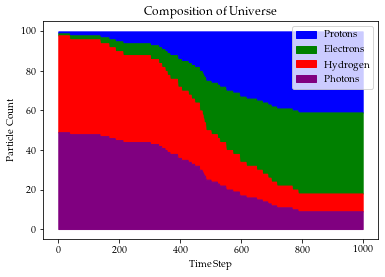

In [29]:
plt.fill_between(t, photon_count + hydrogen_count + electron_count, photon_count + hydrogen_count + electron_count + proton_count, label='Protons', color='b')
plt.fill_between(t, photon_count + hydrogen_count, photon_count + hydrogen_count + electron_count, label='Electrons', color='g')
plt.fill_between(t, photon_count, photon_count + hydrogen_count, label='Hydrogen', color='r')
plt.fill_between(t, base, photon_count, label='Photons', color='purple')
plt.legend()
plt.title('Composition of Universe')
plt.xlabel('Time Step')
plt.ylabel('Particle Count')
plt.savefig(os.path.join(here, "Figures", data_name + ' Out.png'))

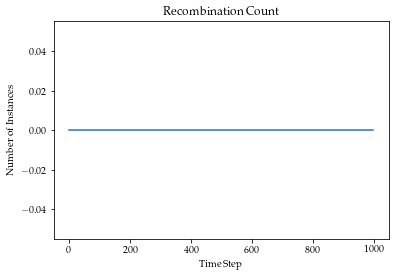

In [30]:
plt.title('Recombination Count')
plt.xlabel('Time Step')
plt.ylabel('Number of Instances')
plt.plot(recombination_count)
plt.savefig(os.path.join(here, "Figures", data_name + ' Recombination.png'), dpi=300)

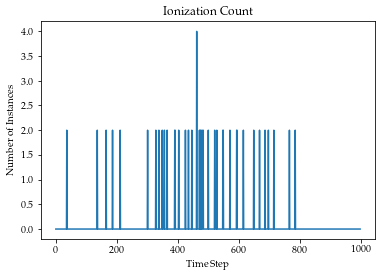

In [31]:
plt.title('Ionization Count')
plt.xlabel('Time Step')
plt.ylabel('Number of Instances')
plt.plot(ionization_count)
plt.savefig(os.path.join(here, "Figures", data_name + ' Ionization.png'), dpi=300)

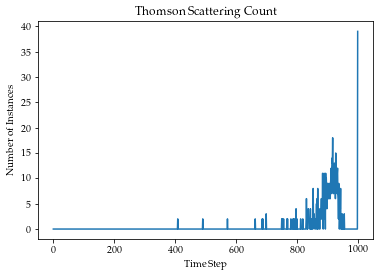

In [32]:
plt.title('Thomson Scattering Count')
plt.xlabel('Time Step')
plt.ylabel('Number of Instances')
plt.plot(thomson_count)
plt.savefig(os.path.join(here, "Figures", data_name + ' Thomson.png'), dpi=300)

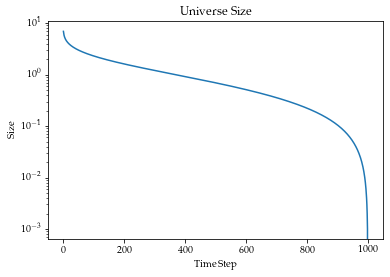

In [33]:
plt.title('Universe Size')
plt.xlabel('Time Step')
plt.ylabel('Size')
sizes = np.abs(np.array([u.size for u in us]))
plt.plot(sizes)
plt.yscale('log')
plt.savefig(os.path.join(here, "Figures", data_name + ' Size - Logarithmic.png'), dpi=300)

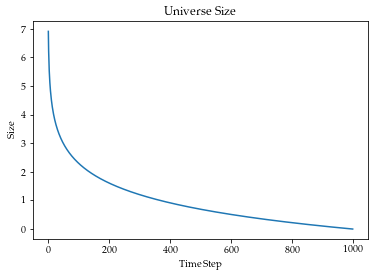

In [34]:
plt.title('Universe Size')
plt.xlabel('Time Step')
plt.ylabel('Size')
sizes = np.abs(np.array([u.size for u in us]))
plt.plot(sizes)
# plt.yscale('log')
plt.savefig(os.path.join(here, "Figures", data_name + ' Size - Linear.png'), dpi=300)

## Render Universes
Render a map of the background radiation of the universe at each time step. The photons are projected down to a sphere surrounding a point at the arbitrary center of the universe (where we are!). The redshift for each photon is calculated based on its velocity and the rate of the universe's expansion and then the wavelengths are normalized to be shown only within the visible spectrum.

100%|██████████| 999/999 [10:24<00:00,  1.60it/s]


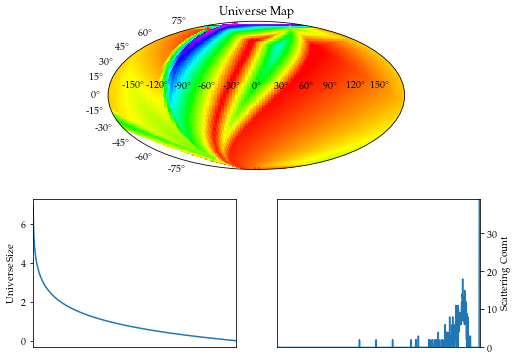

In [35]:
fig = plt.figure(figsize=(8,6))
ax2 = plt.subplot(223)
ax3 = plt.subplot(224)
ax = plt.subplot(211, projection='mollweide')
max_size = max(np.abs(sizes))
max_thomson = max(np.abs(thomson_count))
ongoing_sizes = [np.nan] * (len(us) - 1)
ongoing_thomsons = [np.nan] * (len(us) - 1)
for i in tqdm(range(len(us) - 1)):
    ax.cla()
    ax2.cla()
    ax3.cla()
    final_u = us[i]
    pre_final_u = us[i + 1]
    time_step = 0.001
    zs = []
    for p in final_u.particles:
        if p.type == 'photon':
            zs.append(redshift(p, pre_final_u, time_step))
    wl = [wavelength(z) for z in zs]
    wl = np.array(list(wl) + list(wl))
    cmb = get_cmb(final_u)
    x, y, z = cmb
    theta = np.arctan(np.sqrt(x ** 2 + y ** 2) / z)
    phi = np.arctan(y / x)
    phi_2 = phi + np.pi
    phi = np.array(list(phi) + list(phi_2)) - np.pi / 2
    theta = np.array(list(theta) + list(theta))
    lon = np.linspace(-np.pi, np.pi, 100)
    lat = np.linspace(-np.pi, np.pi, 200)
    Lon, Lat = np.meshgrid(lon, lat)
    interp = griddata((2 * phi, theta), wl, (Lon, Lat), method='linear')
    size = final_u.size
    ongoing_sizes[i] = np.abs(size)
    ongoing_thomsons[i] = thomson_count[i]
    # ax2.set_ylim(0, max_size)
    ax2.set_xlim(0, len(us) - 1)
    ax.set_title('Universe Map')
    ax2.set_ylabel('Universe Size')
    ax3.set_ylim(0, max_thomson)
    ax3.set_xlim(0, len(us) - 1)
    ax3.set_ylabel('Scattering Count')
    ax3.yaxis.set_label_position("right")
    ax3.yaxis.tick_right()
    # ax2.set_yscale('log')
    ax2.set_xticks([])
    ax3.set_xticks([])
    try:
        ax.pcolormesh(lon, lat, interp, cmap=plt.cm.gist_rainbow)
        ax2.plot(ongoing_sizes)
        ax3.plot(ongoing_thomsons)
        ax.scatter(2 * phi, theta, c=wl, cmap=plt.cm.gist_rainbow, marker='+')
        os.makedirs(os.path.join(here, 'Data Sets/' + data_name + ' Maps'), exist_ok=True)
        out_id = (len(str(len(us))) - len(str(i + 1))) * '0' + str(i + 1)
        plt.savefig(os.path.join(here, 'Data Sets/' + data_name + ' Maps', out_id + '.png'), dpi=300)
    except:
        pass

## Convert to Video
Combine the rendered background radiation plots to a single mp4 video. This requires ffmpeg.

In [36]:
l = str(len(out_id))
s = 'ffmpeg -framerate 15 -i "Data Sets/' + data_name + ' Maps"/%0' + l + 'd.png -c:v libx264 -r 15 Figures/"' + data_name + '".mp4'
os.system(s)

ffmpeg version 4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (GCC)
  configuration: --prefix=/usr --bindir=/usr/bin --datadir=/usr/share/ffmpeg --docdir=/usr/share/doc/ffmpeg --incdir=/usr/include/ffmpeg --libdir=/usr/lib64 --mandir=/usr/share/man --arch=x86_64 --optflags='-O2 -flto=auto -ffat-lto-objects -fexceptions -g -grecord-gcc-switches -pipe -Wall -Werror=format-security -Wp,-D_FORTIFY_SOURCE=2 -Wp,-D_GLIBCXX_ASSERTIONS -specs=/usr/lib/rpm/redhat/redhat-hardened-cc1 -fstack-protector-strong -specs=/usr/lib/rpm/redhat/redhat-annobin-cc1 -m64 -mtune=generic -fasynchronous-unwind-tables -fstack-clash-protection -fcf-protection' --extra-ldflags='-Wl,-z,relro -Wl,--as-needed -Wl,-z,now -specs=/usr/lib/rpm/redhat/redhat-hardened-ld -specs=/usr/lib/rpm/redhat/redhat-annobin-cc1 ' --extra-cflags=' -I/usr/include/rav1e' --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libvo-amrwbenc --enable-version3 --enable-bzlib --enable-chromaprint --disable-cr

0